# 能動学習 (Active Learning) デモ — 画像分類編 (手書き数字)

## 概要
**能動学習**とは、モデル自身が「次にどのデータにラベルを付けるべきか」を選ぶ手法です。

本ノートブックでは、手書き数字画像の分類タスクを題材に、能動学習の効果を体験します。
回帰版デモ (`active_learning_demo.ipynb`) と対比しながら、**分類問題における能動学習**の仕組みを理解しましょう。

データセットには scikit-learn 組み込みの `load_digits`（8×8ピクセル、0〜9の手書き数字 1797枚）を使用します。

### 回帰版との違い
| | 回帰版 | 分類版 (本デモ) |
|---|---|---|
| データ | 2D連続関数 | 手書き数字画像 (8×8) |
| モデル | ガウス過程回帰 (GPR) | ロジスティック回帰 |
| 不確実性の指標 | 予測標準偏差 σ(x) | 予測エントロピー H(x) |
| 評価指標 | RMSE | Accuracy |

### このデモで体験すること
1. 少数の初期ラベル付きデータで分類モデルを構築
2. 能動学習ループ：予測が不確実なサンプルを逐次追加
3. ランダムサンプリングとの性能比較

### 用語
| 用語 | 説明 |
|------|------|
| ラベルなしプール | まだラベルを取得していない画像の集合 |
| エントロピー | 予測確率分布の不確実性を表す指標（高いほど不確実） |
| 獲得関数 | 次にどのサンプルにラベルを付けるべきかを決める基準 |
| マージンサンプリング | 上位2クラスの予測確率の差が小さいサンプルを選ぶ戦略 |

## 1. 準備

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 10

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

## 2. 手書き数字データの読み込みと確認

scikit-learn 組み込みの `load_digits` データセットを使用します。
0〜9の手書き数字画像（8×8ピクセル、グレースケール）が 1797枚含まれています。

In [2]:
# 手書き数字データの読み込み
digits = load_digits()
X_all, y_all = digits.data, digits.target

# テストセットを分離
X_work, X_test, y_work, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
)

# 特徴量のスケーリング
scaler = StandardScaler()
X_work = scaler.fit_transform(X_work)
X_test = scaler.transform(X_test)

IMG_SIZE = 8  # 画像の幅・高さ

print(f"全データ:     {len(X_all)} 枚")
print(f"作業用データ: {X_work.shape[0]} 枚")
print(f"テストデータ: {X_test.shape[0]} 枚")
print(f"画像サイズ:   {IMG_SIZE}×{IMG_SIZE} = {X_work.shape[1]} ピクセル")
print(f"クラス数:     {len(np.unique(y_work))} (0〜9)")

全データ:     1797 枚
作業用データ: 1437 枚
テストデータ: 360 枚
画像サイズ:   8×8 = 64 ピクセル
クラス数:     10 (0〜9)


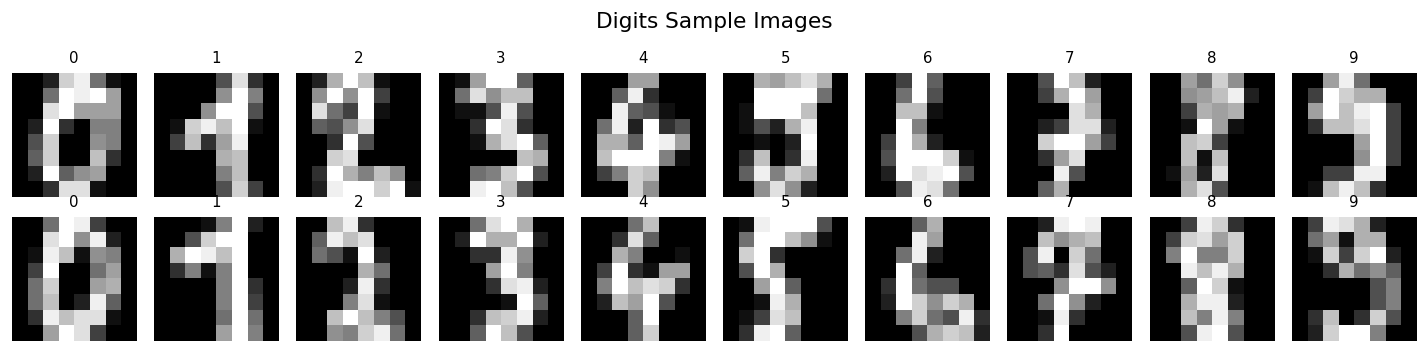

In [3]:
# サンプル画像の表示
fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    idx = np.where(y_work == i % 10)[0][i // 10]
    img = scaler.inverse_transform(X_work[idx:idx+1]).reshape(IMG_SIZE, IMG_SIZE)
    ax.imshow(img, cmap="gray")
    ax.set_title(str(y_work[idx]), fontsize=9)
    ax.axis("off")
plt.suptitle("Digits Sample Images", fontsize=13)
plt.tight_layout()
plt.show()

## 3. 初期ラベル付きデータの準備

能動学習のスタート地点として、少数のラベル付きデータを用意します。
残りは「ラベルなしプール」として、能動学習で逐次ラベルを取得していきます。

（実際のアプリケーションでは、ラベル付けは人間のアノテーターが行います。
ここでは元のラベルを「アノテーターに問い合わせた結果」として使います。）

In [4]:
N_INITIAL = 50  # 初期ラベル付きデータ数（各クラス5枚）

# 各クラスから均等にサンプリング
initial_indices = []
for digit in range(10):
    class_indices = np.where(y_work == digit)[0]
    chosen = rng.choice(class_indices, size=N_INITIAL // 10, replace=False)
    initial_indices.extend(chosen)
initial_indices = np.array(initial_indices)

# 初期データとプールに分割
pool_indices = np.setdiff1d(np.arange(len(X_work)), initial_indices)

X_labeled = X_work[initial_indices]
y_labeled = y_work[initial_indices]
X_pool = X_work[pool_indices]
y_pool = y_work[pool_indices]  # 「まだ見えない」ラベル

print(f"初期ラベル付きデータ: {len(X_labeled)} 枚")
print(f"ラベルなしプール:     {len(X_pool)} 枚")
print(f"テストデータ:         {len(X_test)} 枚")
print(f"\n初期データのクラス分布:")
for digit in range(10):
    count = np.sum(y_labeled == digit)
    print(f"  {digit}: {count} 枚", end="  ")
    if digit == 4:
        print()

初期ラベル付きデータ: 50 枚
ラベルなしプール:     1387 枚
テストデータ:         360 枚

初期データのクラス分布:
  0: 5 枚    1: 5 枚    2: 5 枚    3: 5 枚    4: 5 枚  
  5: 5 枚    6: 5 枚    7: 5 枚    8: 5 枚    9: 5 枚  

## 4. 分類モデルの構築と不確実性の計算

分類問題では、予測確率から**不確実性**を計算できます。
代表的な指標として以下の3つがあります：

### 不確実性の指標

1. **エントロピー (Entropy Sampling)**
$$H(x) = -\sum_{k=1}^{K} p_k(x) \log p_k(x)$$
予測確率分布が均一に近いほどエントロピーが高い（＝不確実）

2. **マージン (Margin Sampling)**
$$M(x) = p_{\text{1st}}(x) - p_{\text{2nd}}(x)$$
上位2クラスの確率差が小さいほど不確実（マージンが小さいものを選ぶ）

3. **最小確信度 (Least Confidence)**
$$LC(x) = 1 - p_{\text{max}}(x)$$
最も確率の高いクラスの確率が低いほど不確実

本デモでは**エントロピーサンプリング**を使用します。

In [5]:
def build_classifier(X_train, y_train):
    """ロジスティック回帰モデルを構築・学習する"""
    clf = LogisticRegression(
        max_iter=500,
        solver="lbfgs",
        random_state=RANDOM_STATE,
        C=1.0,
    )
    clf.fit(X_train, y_train)
    return clf


def compute_entropy(clf, X):
    """予測確率からエントロピーを計算する"""
    proba = clf.predict_proba(X)
    # log(0)を避けるためにクリップ
    proba = np.clip(proba, 1e-10, 1.0)
    entropy = -np.sum(proba * np.log(proba), axis=1)
    return entropy


def evaluate_classifier(clf, X_test, y_test):
    """テストセットでの精度を計算"""
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [6]:
# 初期モデルの学習と評価
clf_init = build_classifier(X_labeled, y_labeled)
acc_init = evaluate_classifier(clf_init, X_test, y_test)
print(f"初期モデルの精度: {acc_init:.4f} ({len(X_labeled)} 枚で学習)")

初期モデルの精度: 0.8583 (50 枚で学習)


C:\Users\akihi\AppData\Local\Temp\ipykernel_39688\3947760019.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


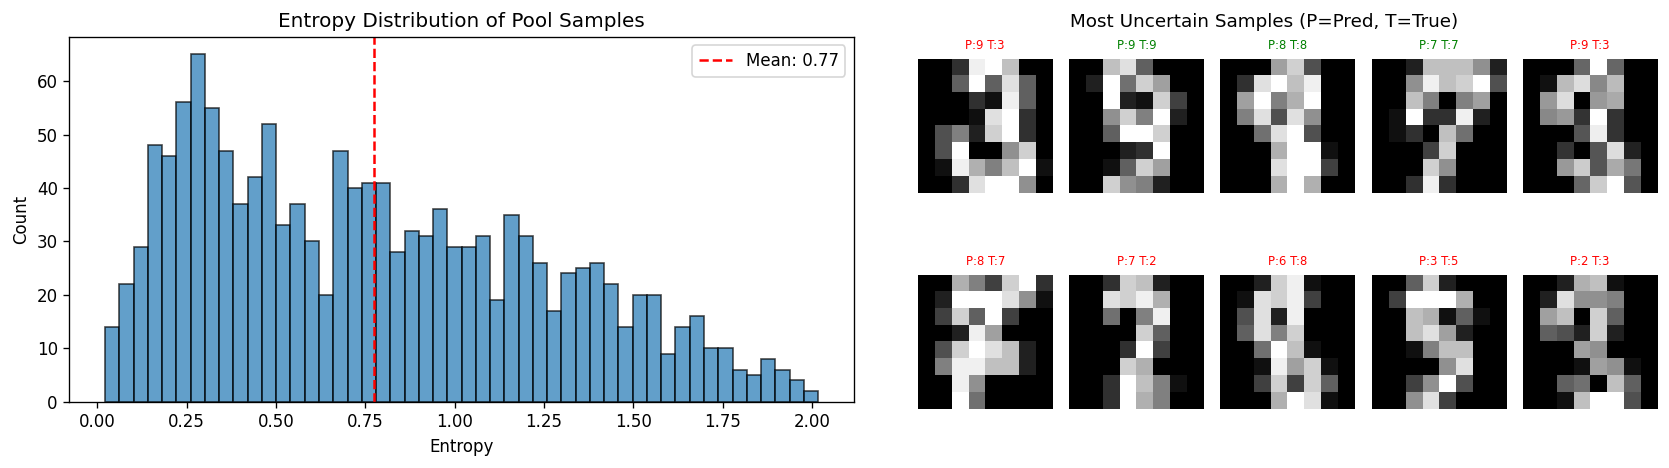

In [7]:
# 初期モデルのエントロピー分布を可視化
entropy_init = compute_entropy(clf_init, X_pool)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# エントロピーのヒストグラム
ax = axes[0]
ax.hist(entropy_init, bins=50, edgecolor="black", alpha=0.7)
ax.axvline(np.mean(entropy_init), color="red", linestyle="--", label=f"Mean: {np.mean(entropy_init):.2f}")
ax.set_xlabel("Entropy")
ax.set_ylabel("Count")
ax.set_title("Entropy Distribution of Pool Samples")
ax.legend()

# エントロピーが高いサンプル（モデルが迷っている画像）を表示
ax = axes[1]
top_k = 10
top_indices = np.argsort(entropy_init)[-top_k:]
for i, idx in enumerate(top_indices):
    img = scaler.inverse_transform(X_pool[idx:idx+1]).reshape(IMG_SIZE, IMG_SIZE)
    ax_sub = fig.add_axes([0.55 + (i % 5) * 0.09, 0.55 - (i // 5) * 0.45, 0.08, 0.35])
    ax_sub.imshow(img, cmap="gray")
    pred = clf_init.predict(X_pool[idx:idx+1])[0]
    true = y_pool[idx]
    ax_sub.set_title(f"P:{pred} T:{true}", fontsize=7, color="red" if pred != true else "green")
    ax_sub.axis("off")
axes[1].axis("off")
axes[1].set_title("Most Uncertain Samples (P=Pred, T=True)", fontsize=11)

plt.tight_layout()
plt.show()

## 5. 能動学習ループ

### 獲得関数：エントロピーサンプリング

候補プールの中から**予測エントロピーが最大のサンプル**を選んでラベルを付けます。

```
次のサンプル = argmax_{x ∈ プール} H(x)
```

直感的には「モデルがどの数字か最も迷っている画像」を優先的にラベル付けする、という戦略です。

回帰版では GPR の予測標準偏差 σ(x) を使いましたが、分類版ではエントロピー H(x) が同様の役割を果たします。

In [8]:
def active_learning_loop(X_init, y_init, X_pool, y_pool,
                         X_test, y_test, n_iterations=50, batch_size=10):
    """
    能動学習ループ（エントロピーサンプリング）

    Parameters
    ----------
    X_init, y_init : 初期ラベル付きデータ
    X_pool, y_pool : ラベルなしプール（y_poolは「問い合わせれば得られる」真のラベル）
    X_test, y_test : テストデータ
    n_iterations   : 能動学習の反復回数
    batch_size     : 1回に追加するサンプル数

    Returns
    -------
    history : dict（精度履歴、選択されたサンプルなど）
    """
    X_train = X_init.copy()
    y_train = y_init.copy()
    X_remaining = X_pool.copy()
    y_remaining = y_pool.copy()

    acc_history = []
    n_samples_history = []
    selected_images = []  # 選択された画像を保存
    selected_entropies = []

    for i in range(n_iterations):
        # 1. 分類器を学習
        clf = build_classifier(X_train, y_train)
        acc = evaluate_classifier(clf, X_test, y_test)
        acc_history.append(acc)
        n_samples_history.append(len(X_train))

        if i % 10 == 0:
            print(f"  Iteration {i:3d}: n={len(X_train):5d}, Accuracy={acc:.4f}")

        # 2. プールでのエントロピーを計算
        entropy = compute_entropy(clf, X_remaining)

        # 3. エントロピーが最大のサンプルを選択
        idx = np.argsort(entropy)[-batch_size:]
        selected_entropies.append(entropy[idx].mean())

        # 4. 選択したサンプルを学習データに追加
        if i < 5:  # 最初の数回は画像を保存
            selected_images.append((X_remaining[idx].copy(), y_remaining[idx].copy()))
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])

        # 5. プールから除去
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    # 最終モデルの評価
    clf_final = build_classifier(X_train, y_train)
    acc_final = evaluate_classifier(clf_final, X_test, y_test)
    acc_history.append(acc_final)
    n_samples_history.append(len(X_train))
    print(f"  Final:        n={len(X_train):5d}, Accuracy={acc_final:.4f}")

    return {
        "acc_history": acc_history,
        "n_samples_history": n_samples_history,
        "selected_images": selected_images,
        "selected_entropies": selected_entropies,
        "clf_final": clf_final,
        "X_train_final": X_train,
        "y_train_final": y_train,
    }

In [9]:
N_ITERATIONS = 50
BATCH_SIZE = 5

print(f"能動学習を実行中... ({N_ITERATIONS} iterations, batch_size={BATCH_SIZE})")
al_result = active_learning_loop(
    X_labeled, y_labeled,
    X_pool, y_pool,
    X_test, y_test,
    n_iterations=N_ITERATIONS,
    batch_size=BATCH_SIZE,
)
print(f"\nAccuracy: {al_result['acc_history'][0]:.4f} → {al_result['acc_history'][-1]:.4f}")
print(f"学習データ: {N_INITIAL} → {al_result['n_samples_history'][-1]} 枚")

能動学習を実行中... (50 iterations, batch_size=5)
  Iteration   0: n=   50, Accuracy=0.8583
  Iteration  10: n=  100, Accuracy=0.9194
  Iteration  20: n=  150, Accuracy=0.9167
  Iteration  30: n=  200, Accuracy=0.9361
  Iteration  40: n=  250, Accuracy=0.9556
  Final:        n=  300, Accuracy=0.9583

Accuracy: 0.8583 → 0.9583
学習データ: 50 → 300 枚


### 能動学習が選んだ画像の可視化

各イテレーションで能動学習が選んだ画像を確認します。
モデルが「判別に迷っている画像」が優先的に選ばれていることがわかります。

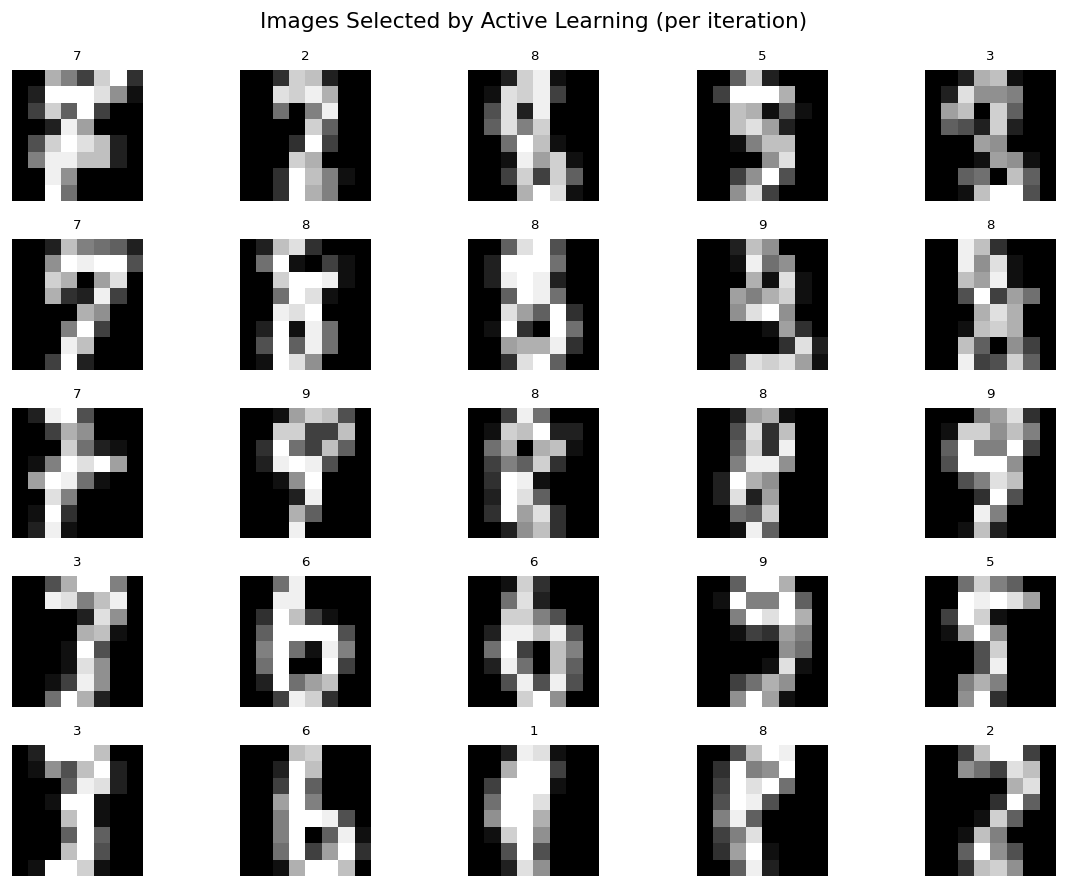

In [10]:
# 能動学習が選んだ画像を表示（最初の5イテレーション）
n_show = min(5, len(al_result["selected_images"]))
fig, axes = plt.subplots(n_show, BATCH_SIZE, figsize=(10, n_show * 1.5))

for row in range(n_show):
    X_sel, y_sel = al_result["selected_images"][row]
    for col in range(min(BATCH_SIZE, len(X_sel))):
        ax = axes[row, col] if n_show > 1 else axes[col]
        img = scaler.inverse_transform(X_sel[col:col+1]).reshape(IMG_SIZE, IMG_SIZE)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"{y_sel[col]}", fontsize=8)
        ax.axis("off")
    if n_show > 1:
        axes[row, 0].set_ylabel(f"Iter {row+1}", fontsize=9, rotation=0, labelpad=30)

plt.suptitle("Images Selected by Active Learning (per iteration)", fontsize=13)
plt.tight_layout()
plt.show()

## 6. ランダムサンプリングとの比較

能動学習の効果を示すために、プールからランダムに画像を選ぶ戦略と比較します。

In [11]:
def random_sampling_loop(X_init, y_init, X_pool, y_pool,
                         X_test, y_test, n_iterations=50, batch_size=5, seed=0):
    """ランダムサンプリングによるベースライン"""
    rng_local = np.random.default_rng(seed)
    X_train = X_init.copy()
    y_train = y_init.copy()
    X_remaining = X_pool.copy()
    y_remaining = y_pool.copy()

    acc_history = []
    n_samples_history = []

    for i in range(n_iterations):
        clf = build_classifier(X_train, y_train)
        acc = evaluate_classifier(clf, X_test, y_test)
        acc_history.append(acc)
        n_samples_history.append(len(X_train))

        if i % 10 == 0:
            print(f"  Iteration {i:3d}: n={len(X_train):5d}, Accuracy={acc:.4f}")

        # ランダムに選択
        idx = rng_local.choice(len(X_remaining), size=batch_size, replace=False)
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    clf_final = build_classifier(X_train, y_train)
    acc_final = evaluate_classifier(clf_final, X_test, y_test)
    acc_history.append(acc_final)
    n_samples_history.append(len(X_train))
    print(f"  Final:        n={len(X_train):5d}, Accuracy={acc_final:.4f}")

    return {
        "acc_history": acc_history,
        "n_samples_history": n_samples_history,
        "clf_final": clf_final,
        "X_train_final": X_train,
        "y_train_final": y_train,
    }


print(f"ランダムサンプリングを実行中... ({N_ITERATIONS} iterations, batch_size={BATCH_SIZE})")
rand_result = random_sampling_loop(
    X_labeled, y_labeled,
    X_pool, y_pool,
    X_test, y_test,
    n_iterations=N_ITERATIONS,
    batch_size=BATCH_SIZE,
)
print(f"\nAccuracy: {rand_result['acc_history'][0]:.4f} → {rand_result['acc_history'][-1]:.4f}")

ランダムサンプリングを実行中... (50 iterations, batch_size=5)
  Iteration   0: n=   50, Accuracy=0.8583
  Iteration  10: n=  100, Accuracy=0.8806
  Iteration  20: n=  150, Accuracy=0.9056
  Iteration  30: n=  200, Accuracy=0.9028
  Iteration  40: n=  250, Accuracy=0.9222
  Final:        n=  300, Accuracy=0.9250

Accuracy: 0.8583 → 0.9250


## 7. 結果の比較

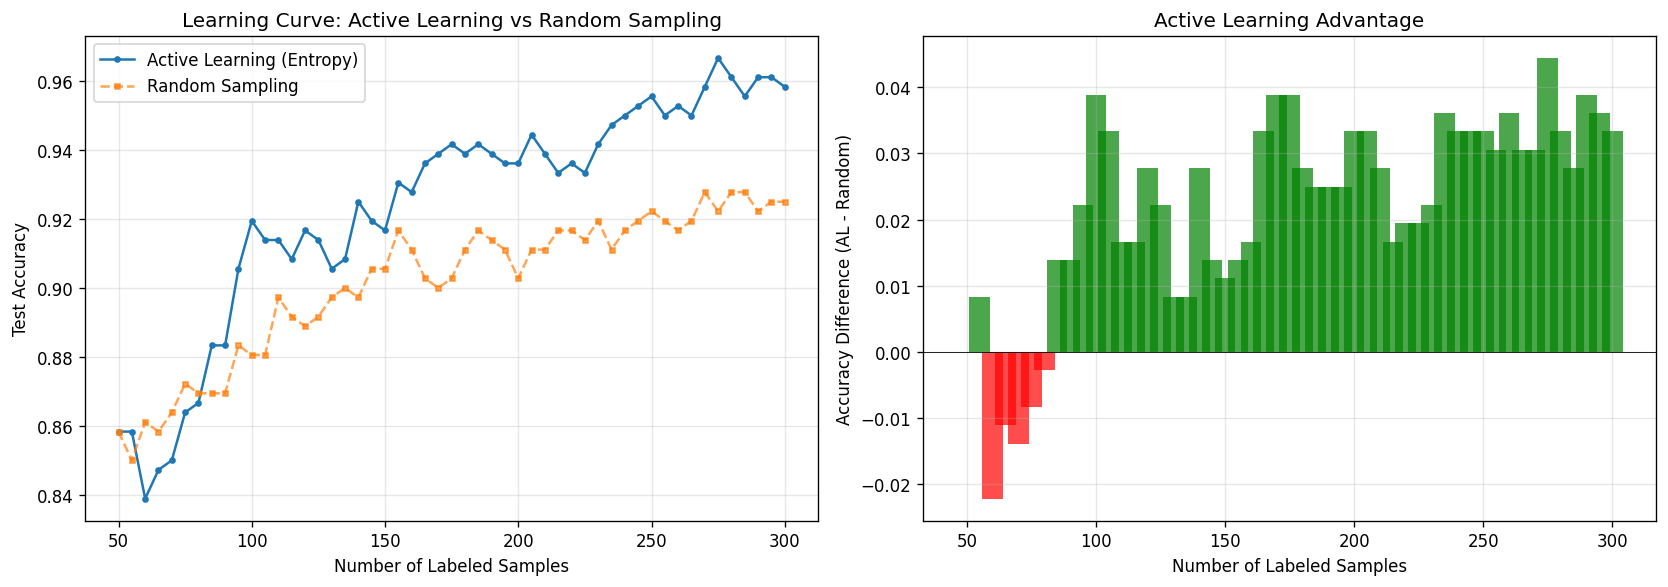


最終Accuracy比較 (300 samples)
  Active Learning:  0.9583
  Random Sampling:  0.9250
  Difference:       +0.0333


In [12]:
# 学習曲線の比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy曲線
ax = axes[0]
ax.plot(al_result["n_samples_history"], al_result["acc_history"],
        "o-", label="Active Learning (Entropy)", markersize=3)
ax.plot(rand_result["n_samples_history"], rand_result["acc_history"],
        "s--", label="Random Sampling", markersize=3, alpha=0.7)
ax.set_xlabel("Number of Labeled Samples")
ax.set_ylabel("Test Accuracy")
ax.set_title("Learning Curve: Active Learning vs Random Sampling")
ax.legend()
ax.grid(True, alpha=0.3)

# 差分プロット
ax = axes[1]
acc_diff = np.array(al_result["acc_history"]) - np.array(rand_result["acc_history"])
ax.bar(al_result["n_samples_history"], acc_diff, width=8, alpha=0.7,
       color=["green" if d > 0 else "red" for d in acc_diff])
ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Number of Labeled Samples")
ax.set_ylabel("Accuracy Difference (AL - Random)")
ax.set_title("Active Learning Advantage")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*55}")
print(f"最終Accuracy比較 ({al_result['n_samples_history'][-1]} samples)")
print(f"{'='*55}")
print(f"  Active Learning:  {al_result['acc_history'][-1]:.4f}")
print(f"  Random Sampling:  {rand_result['acc_history'][-1]:.4f}")
diff = al_result['acc_history'][-1] - rand_result['acc_history'][-1]
print(f"  Difference:       {diff:+.4f}")

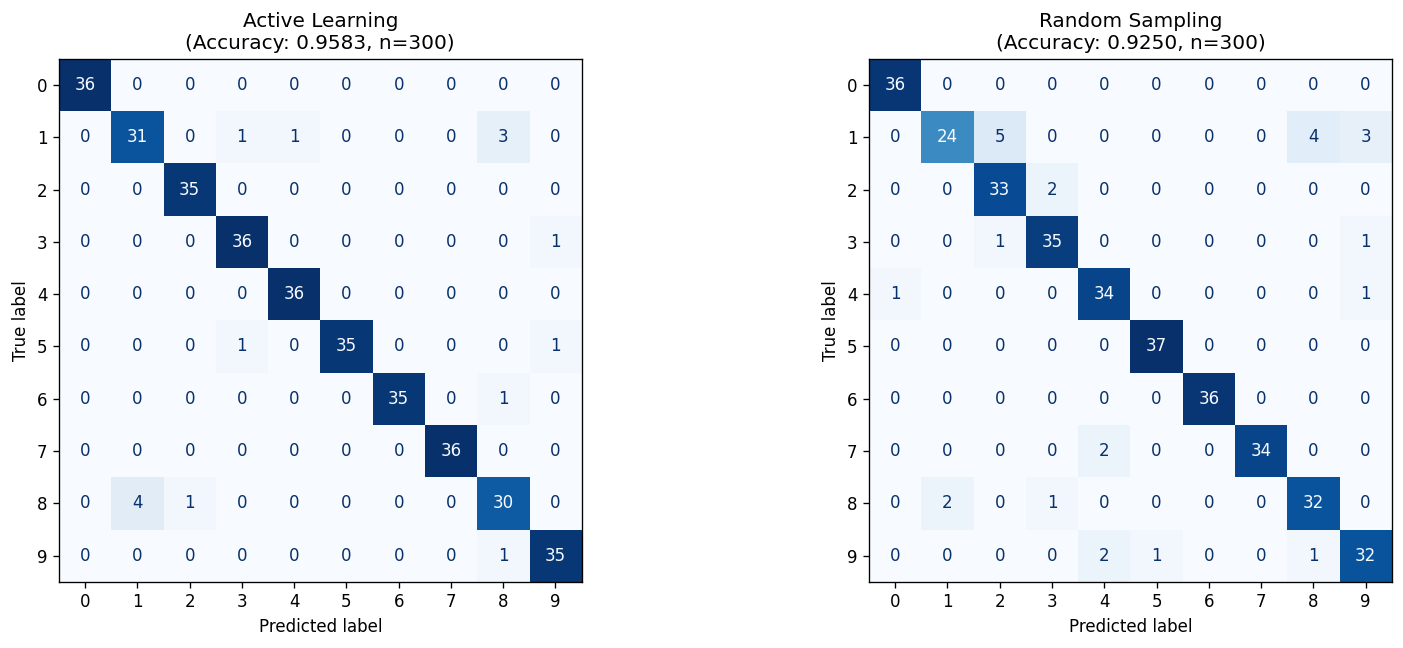

In [13]:
# 混同行列の比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

for ax, (result, label) in zip(axes, [
    (al_result, "Active Learning"),
    (rand_result, "Random Sampling"),
]):
    clf = result["clf_final"]
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    acc = result["acc_history"][-1]
    ax.set_title(f"{label}\n(Accuracy: {acc:.4f}, n={result['n_samples_history'][-1]})")

plt.tight_layout()
plt.show()

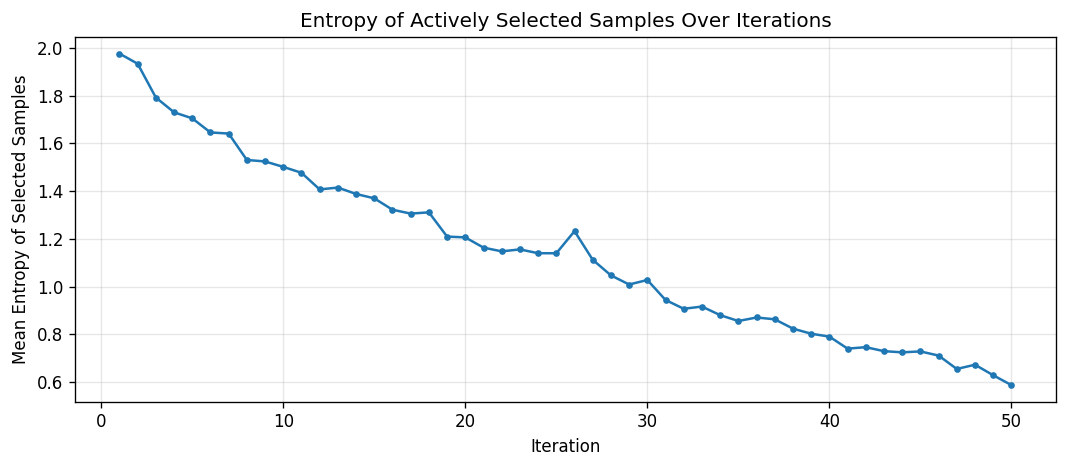

In [14]:
# エントロピーの推移（能動学習が選ぶサンプルの不確実性の変化）
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(range(1, len(al_result["selected_entropies"]) + 1),
        al_result["selected_entropies"], "o-", markersize=3)
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean Entropy of Selected Samples")
ax.set_title("Entropy of Actively Selected Samples Over Iterations")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. クラスごとの分析

能動学習がどのクラス（数字）を重点的にサンプリングしたかを分析します。

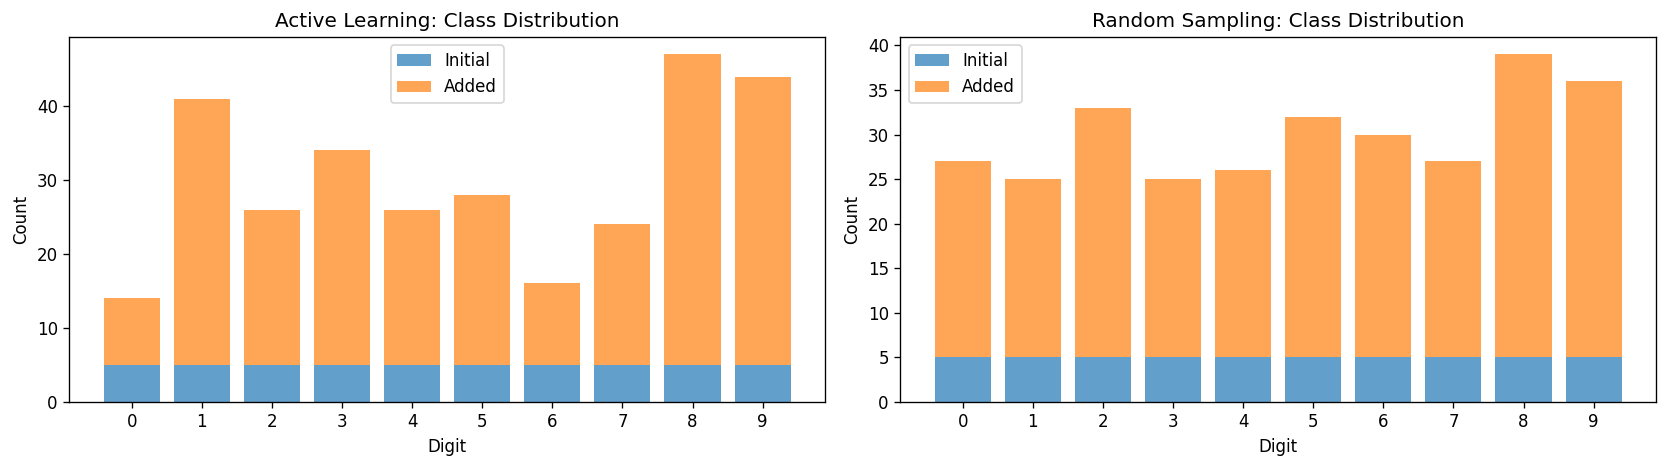

能動学習で追加されたサンプルのクラス分布:
  0:   9 ████
  1:  36 ██████████████████
  2:  21 ██████████
  3:  29 ██████████████
  4:  21 ██████████
  5:  23 ███████████
  6:  11 █████
  7:  19 █████████
  8:  42 █████████████████████
  9:  39 ███████████████████


In [15]:
# 各手法の最終学習データにおけるクラス分布
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, (result, label) in zip(axes, [
    (al_result, "Active Learning"),
    (rand_result, "Random Sampling"),
]):
    counts = [np.sum(result["y_train_final"] == d) for d in range(10)]
    initial_counts = [np.sum(y_labeled == d) for d in range(10)]
    added_counts = [c - ic for c, ic in zip(counts, initial_counts)]

    x = np.arange(10)
    ax.bar(x, initial_counts, label="Initial", alpha=0.7)
    ax.bar(x, added_counts, bottom=initial_counts, label="Added", alpha=0.7)
    ax.set_xlabel("Digit")
    ax.set_ylabel("Count")
    ax.set_title(f"{label}: Class Distribution")
    ax.set_xticks(range(10))
    ax.legend()

plt.tight_layout()
plt.show()

# 能動学習で追加されたサンプルのクラス分布
al_added = al_result["y_train_final"][N_INITIAL:]
print("能動学習で追加されたサンプルのクラス分布:")
for digit in range(10):
    count = np.sum(al_added == digit)
    bar = "█" * (count // 2)
    print(f"  {digit}: {count:3d} {bar}")

## 9. まとめ

### 観察されたこと

1. **学習曲線**: 能動学習はランダムサンプリングよりも少ないラベル付きデータで高い精度を達成
2. **サンプル選択**: 能動学習は「判別が難しい画像」（崩れた字、似た数字の境界ケースなど）を優先的に選択
3. **クラス分布**: 能動学習は識別が難しいクラス（例: 3と8、4と9）を多めにサンプリングする傾向
4. **エントロピー推移**: イテレーションが進むにつれ、選択されるサンプルのエントロピーが低下（モデルの自信が向上）

### 回帰版との対比

| 観点 | 回帰版 (GPR) | 分類版 (本デモ) |
|------|------|------|
| 不確実性 | 予測標準偏差 σ(x) | 予測エントロピー H(x) |
| 選択傾向 | データの空白地帯 → 複雑な領域 | 判別困難なサンプル → 境界ケース |
| 性能指標 | RMSE の低下 | Accuracy の向上 |
| 共通点 | **「モデルが最も不確実な場所を優先的に学習する」**という原理は同じ |

### 能動学習の実応用

- **医療画像**: 専門医によるアノテーションコストが高い → 能動学習で効率化
- **自然言語処理**: テキスト分類のラベル付けコストを削減
- **製造業**: 外観検査における不良品ラベルの効率的な収集

### 発展的な話題

- **Query-by-Committee**: 複数モデルの不一致度を不確実性として使用
- **Bayesian Active Learning**: ベイズ推論ベースの不確実性推定
- **Deep Active Learning**: 深層学習モデルでの能動学習（MC Dropout等）
- **バッチモード能動学習**: 多様性を考慮した複数サンプルの同時選択

### 補足: データセットについて
本デモでは scikit-learn 組み込みの `load_digits`（8×8ピクセル、1797枚）を使用しました。
より高解像度の MNIST（28×28ピクセル、70,000枚）でも同様の手法が適用可能です。
データ規模が大きい場合、能動学習の効果（ラベル付けコスト削減）はさらに顕著になります。